In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *

import warnings
warnings.filterwarnings('ignore')

In [11]:
pgroup='p21185'
runnumber = 26
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
print (jsonfile)

from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
if scan.parameters['scan_name'] != 'dummy':
    if scan.parameters['units'] == ['fs']:
        Timezero_mm = get_timezero_NBS(jsonfile)
        scanvar = scan.readbacks - mm2fs(Timezero_mm, 0)
    else: 
        scanvar = scan.readbacks
    print ('Scan contains {} step(s), scanvar goes from {:.2f} to {:.2f} {}'.format(len(scan), scanvar[0], scanvar[-1], scan.parameters['units'][0]))
else:
    print ('No motors moved')

run: 0026
/sf/alvra/data/p21185/raw/run0026-FeMn_XES_7400eVpink_200fs_16uJ/meta/scan.json
No motors moved


In [12]:
threshold_low = 0
threshold_high = 100

chosen_point = None

channels_list = []

#####################################################
index = 0
if chosen_point != None:
    index= np.arange(len(scanvar))[(scanvar > chosen_point)][0]
import sfdata.sfdatafile
sfdata.sfdatafile.ju = None
scan = SFScanInfo(jsonfile)

spectrum_on, spectrum_off, avg_on, avg_off, thr_on, thr_off, ROIs, meta = XES_PumpProbe_ROIs(scan, channels_list, threshold_low, threshold_high, index)
print ('------------------------------')
#print ('Loaded acq for scanvar = {:.2f} {}'.format(scanvar[index], scan.parameters['units'][0]))

Processing: run0026-FeMn_XES_7400eVpink_200fs_16uJ
Step 1 of 50: filename acq0001

--------------------------------------------------------------------------------

JF02T09V03:ROI_KaDW     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KaDW_bkg 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KaUP     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KaUP_bkg 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbDW     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbDW_bkg 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbUP     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbUP_bkg 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAR-CVME-TIFALL4:EvtSet 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1001 / 1001 -> 0% loss
complete channels: 9 / 9 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 495 pump and 495 unpump shots
--------------

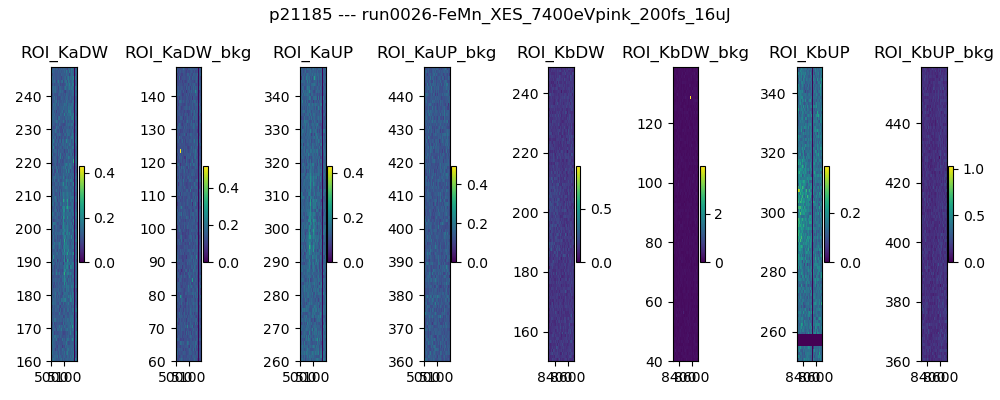

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=len(ROIs), figsize=(10,4))
plt.suptitle(titlestring)
for i, (key, ax) in enumerate(zip(ROIs, axs.flatten())):
    roi2plot = np.average(thr_off[key], axis = 0)
    #xaxis = np.arange(0,29,1)
    xaxis = np.arange(np.array(meta[key+'-roi']).flatten()[-2], np.array(meta[key+'-roi']).flatten()[-1], 1)
    yaxis = np.arange(np.array(meta[key+'-roi']).flatten()[0], np.array(meta[key+'-roi']).flatten()[1], 1)
    plt.sca(ax)
    plt.pcolormesh(xaxis, yaxis, roi2plot)#, vmax=0.001)
    #plt.pcolormesh(roi2plot, vmax=None)
    plt.colorbar()
    plt.title(key.split(':')[-1])
plt.tight_layout()

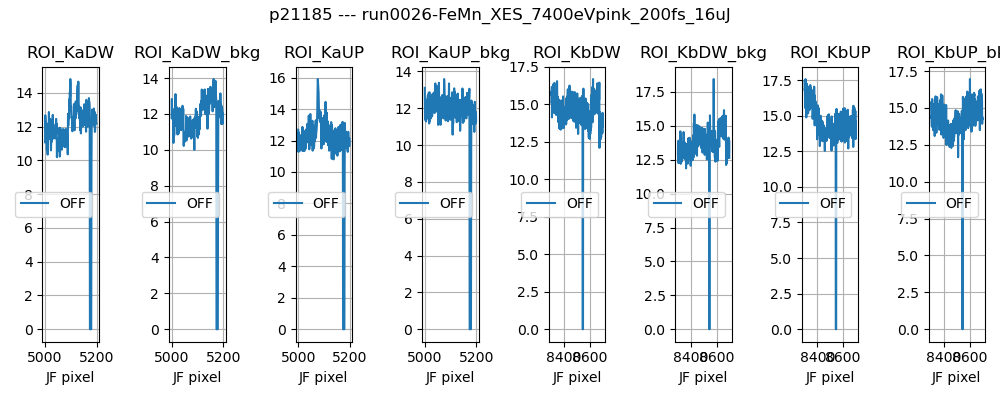

In [15]:
bin_ = 1

fig, axs = plt.subplots(nrows=1, ncols=len(ROIs), figsize=(10,4))
plt.suptitle(titlestring)
for i, (key, ax) in enumerate(zip(ROIs, axs.flatten())):
    spec2plot_on = spectrum_on[key]
    spec2plot_off = spectrum_off[key]
    plt.sca(ax)
    xaxis = np.arange(np.array(meta[key+'-roi']).flatten()[-2], np.array(meta[key+'-roi']).flatten()[-1], 1)
    x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spec2plot_on, spec2plot_off, xaxis, bin_)
    #plt.plot(x_axis_rebin, spectrum_ON_rebin, label = 'ON')
    plt.plot(x_axis_rebin, spectrum_OFF_rebin, label = 'OFF')
    plt.legend (loc='best')
    plt.title(key.split(':')[-1])
    plt.xlabel('JF pixel')
    plt.grid()
plt.tight_layout()

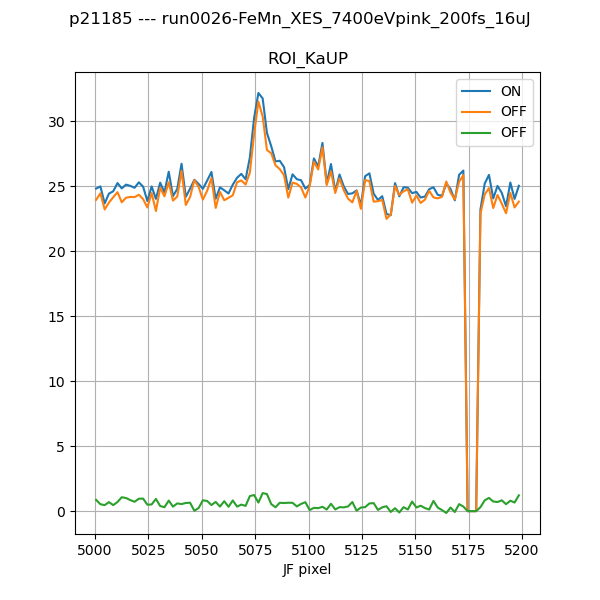

In [16]:
key = 'JF02T09V03:ROI_KaUP'

bin_ = 2

vmin = None
vmax = None

##########################################################

plt.figure(figsize=(6,6))
plt.suptitle(titlestring)

spec2plot_on = spectrum_on[key]
spec2plot_off = spectrum_off[key]
xaxis = np.arange(np.array(meta[key+'-roi']).flatten()[-2], np.array(meta[key+'-roi']).flatten()[-1], 1)
x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spec2plot_on, spec2plot_off, xaxis, bin_)
plt.plot(x_axis_rebin, spectrum_ON_rebin, label = 'ON')
plt.plot(x_axis_rebin, spectrum_OFF_rebin, label = 'OFF')
plt.plot(x_axis_rebin, spectrum_ON_rebin - spectrum_OFF_rebin, label = 'OFF')

plt.legend (loc='best')
plt.title(key.split(':')[-1])
plt.xlabel('JF pixel')
plt.grid()

plt.show()

## Average all the acquisitions in the run

In [67]:
pgroup='p21185'
runnumber = 40
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
print (jsonfile)

from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
if scan.parameters['scan_name'] != 'dummy':
    if scan.parameters['units'] == ['fs']:
        Timezero_mm = get_timezero_NBS(jsonfile)
        scanvar = scan.readbacks - mm2fs(Timezero_mm, 0)
    else: 
        scanvar = scan.readbacks
    print ('Scan contains {} step(s), scanvar goes from {:.2f} to {:.2f} {}'.format(len(scan), scanvar[0], scanvar[-1], scan.parameters['units'][0]))
else:
    print ('No motors moved')

run: 0040
/sf/alvra/data/p21185/raw/run0040-FeOx_RXES_7112eV_150fs_16uJ/meta/scan.json
No motors moved


In [68]:
threshold_low = 5
threshold_high = 15

channels_list = []

reducedir='../Claudio/Reduced_XES_static/'
saveflag = True
#####################################################
import sfdata.sfdatafile
sfdata.sfdatafile.ju = None
scan = SFScanInfo(jsonfile)

spectra_on = []
spectra_off = []
hotpixel=[]
hotpixel2=[]
hotpixel3=[]

for indexfile in range(len(scan)):
#for indexfile in range(15):
    spectrum_on, spectrum_off, avg_on, avg_off, thr_on, thr_off, ROIs, meta = \
    XES_PumpProbe_ROIs(scan, channels_list, threshold_low, threshold_high, indexfile)
    
    spectra_on.append(spectrum_on)
    spectra_off.append(spectrum_off)

run_name = jsonfile.split('/')[-3]
os.makedirs(reducedir+run_name, exist_ok=True)
if saveflag:
    save_data_XES_ROIs(reducedir, run_name, spectra_on, spectra_off, ROIs, meta)

Processing: run0040-FeOx_RXES_7112eV_150fs_16uJ
Step 50 of 50: filename acq0050

--------------------------------------------------------------------------------

JF02T09V03:ROI_KaDW     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KaDW_bkg 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KaUP     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KaUP_bkg 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbDW     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbDW_bkg 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbUP     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbUP_bkg 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAR-CVME-TIFALL4:EvtSet 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1001 / 1001 -> 0% loss
complete channels: 9 / 9 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 495 pump and 495 unpump shots


In [69]:
s_on = {}
s_off = {}
for key in ROIs:
    son = []
    soff = []
    for i in range(len(spectra_on)):
        son.append(spectra_on[i][key])
        soff.append(spectra_off[i][key])
    son = np.array(np.average(son, axis=0))
    soff = np.array(np.average(soff, axis=0))
    s_on[key] = son
    s_off[key] = soff

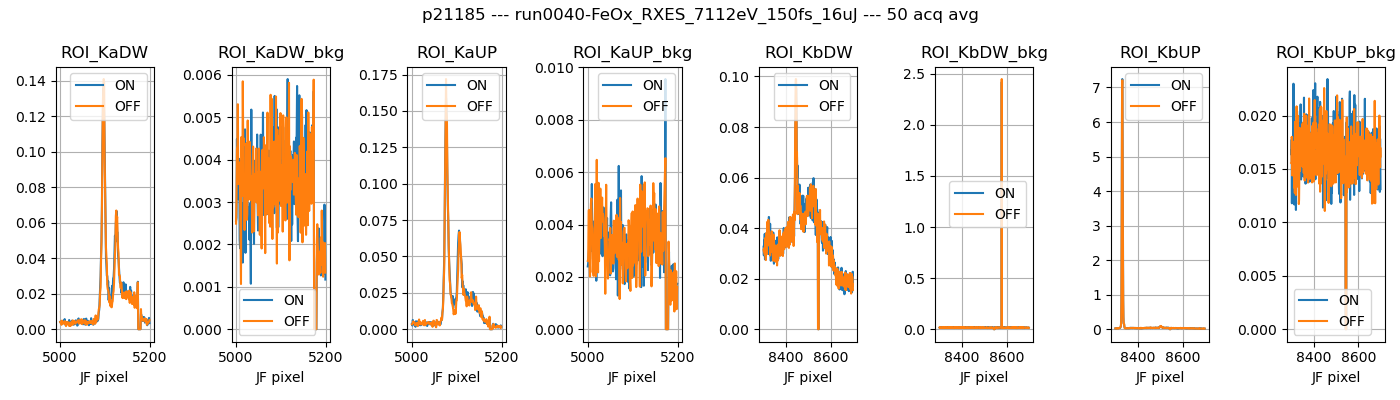

In [70]:
fitelastic = False
bin_ = 1

fig, axs = plt.subplots(nrows=1, ncols=len(ROIs), figsize=(14,4))
plt.suptitle(titlestring+' --- {} acq avg'.format(len(spectra_on)))
for i, (key, ax) in enumerate(zip(ROIs, axs.flatten())):
    spec2plot_on = s_on[key]
    spec2plot_off = s_off[key]
    plt.sca(ax)
    xaxis = np.arange(np.array(meta[key+'-roi']).flatten()[-2], np.array(meta[key+'-roi']).flatten()[-1], 1)
    x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spec2plot_on, spec2plot_off, xaxis, bin_)
    plt.plot(x_axis_rebin, spectrum_ON_rebin, label = 'ON')
    plt.plot(x_axis_rebin, spectrum_OFF_rebin, label = 'OFF')
    
    if fitelastic:
        spectrum_toFit = np.copy(spectrum_ON_rebin[:190])
        Energy_eV_toFit = np.copy(x_axis_rebin[:190])
        fit = Fit(gaussian, estimate_gaussian_parameters)
        fit.estimate(Energy_eV_toFit, spectrum_toFit)
        fit.fit(Energy_eV_toFit,spectrum_toFit) 
        spectrum_fit = fit.eval(Energy_eV_toFit)
        plt.plot(Energy_eV_toFit, spectrum_fit, label = 'fit', color='green')
        print ('peak = {:.2f}'.format(fit.popt[0]))
        print ('width = {:.2f}'.format(fit.popt[2]*2.355))
    
    #plt.ylim(0,0.05)
    #plt.xlim(3100,3180)
    #plt.xlim(1250,1450)
    
    #plt.plot(x_axis_rebin, spectrum_OFF_rebin, label = 'OFF')    
    plt.legend (loc='best')
    plt.title(key.split(':')[-1])
    plt.xlabel('JF pixel')
    plt.grid()
plt.tight_layout()

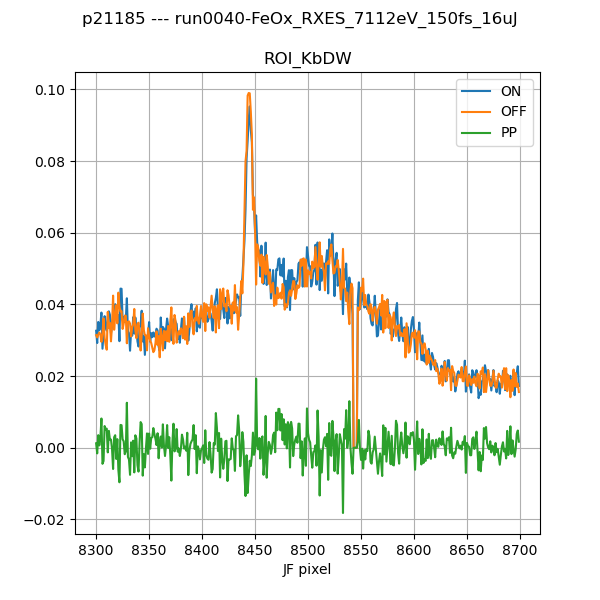

In [80]:
key = 'JF02T09V03:ROI_KbDW'

bin_ = 1

vmin = None
vmax = None

##########################################################

plt.figure(figsize=(6,6))
plt.suptitle(titlestring)

spec2plot_on = s_on[key]
spec2plot_off = s_off[key]
xaxis = np.arange(np.array(meta[key+'-roi']).flatten()[-2], np.array(meta[key+'-roi']).flatten()[-1], 1)
x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spec2plot_on, spec2plot_off, xaxis, bin_)
plt.plot(x_axis_rebin, spectrum_ON_rebin, label = 'ON')
plt.plot(x_axis_rebin, spectrum_OFF_rebin, label = 'OFF')
plt.plot(x_axis_rebin, spectrum_ON_rebin - spectrum_OFF_rebin, label = 'PP')

plt.legend (loc='best')
plt.title(key.split(':')[-1])
plt.xlabel('JF pixel')
plt.grid()

plt.show()

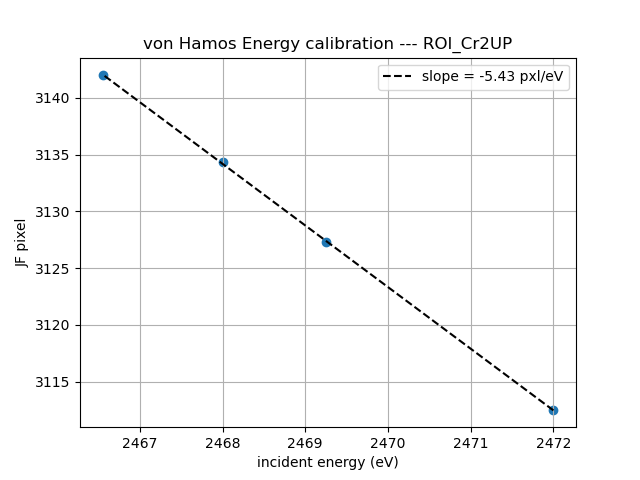

-5.430862659608014 16537.553363439205


In [24]:
energy = np.array([2472, 2469.25, 2468, 2466.55])
pxl = np.array([ 3112.46, 3127.33, 3134.31, 3142.00])

m,b = np.polyfit(energy,pxl, 1) 

plt.figure()
plt.title('von Hamos Energy calibration --- ROI_Cr2UP')
plt.plot (energy, m*energy + b,  '--', color='black', label = 'slope = {:.2f} pxl/eV'.format(m))
plt.scatter(energy, pxl)
#plt.plot(Delay_mm, arrTimes_avg)
plt.xlabel('incident energy (eV)')
plt.ylabel('JF pixel')
plt.legend (loc = 'best')
plt.grid()
plt.show()

print (m,b)

## same plot with Energy calibration

binsize is 0.19 eV


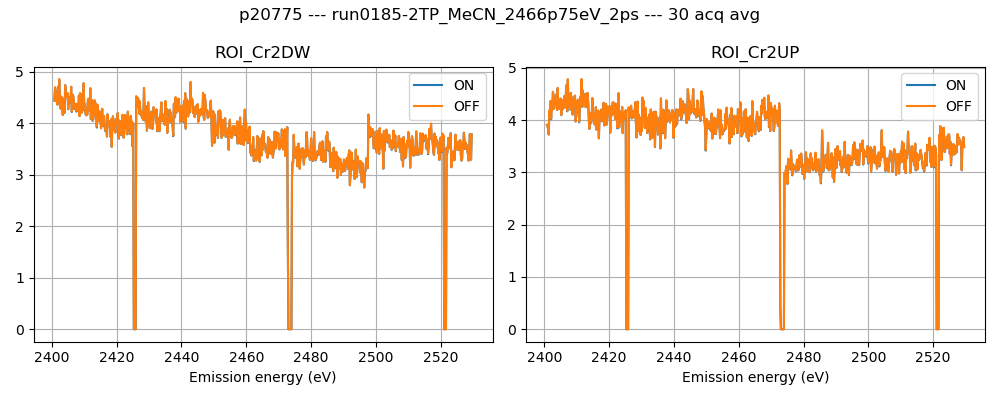

In [25]:
energy_calib = True
bin_ = 1

##########################################

fig, axs = plt.subplots(nrows=1, ncols=len(ROIs), figsize=(10,4))
plt.suptitle(titlestring+' --- {} acq avg'.format(len(spectra_on)))
for i, (key, ax) in enumerate(zip(ROIs, axs.flatten())):
    spec2plot_on = s_on[key]
    spec2plot_off = s_off[key]
    plt.sca(ax)
    xaxis = np.arange(np.array(meta[key+'-roi']).flatten()[-2], np.array(meta[key+'-roi']).flatten()[-1], 1)
    x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spec2plot_on, spec2plot_off, xaxis, bin_)
    xlabel = 'JF pixel'
    if energy_calib:
        x_axis_rebin = (x_axis_rebin-b)/m
        xlabel = 'Emission energy (eV)'
    
    plt.plot(x_axis_rebin, spectrum_ON_rebin, label = 'ON')
    plt.plot(x_axis_rebin, spectrum_OFF_rebin, label = 'OFF')
    
    plt.legend (loc='best')
    plt.title(key.split(':')[-1])
    plt.xlabel(xlabel)
    plt.grid()
    #plt.xlim(2440,2480)
    #plt.ylim(0, 0.02)
plt.tight_layout()

print ('binsize is {:.2f} eV'.format(bin_/5.4))

binsize is 0.56 eV


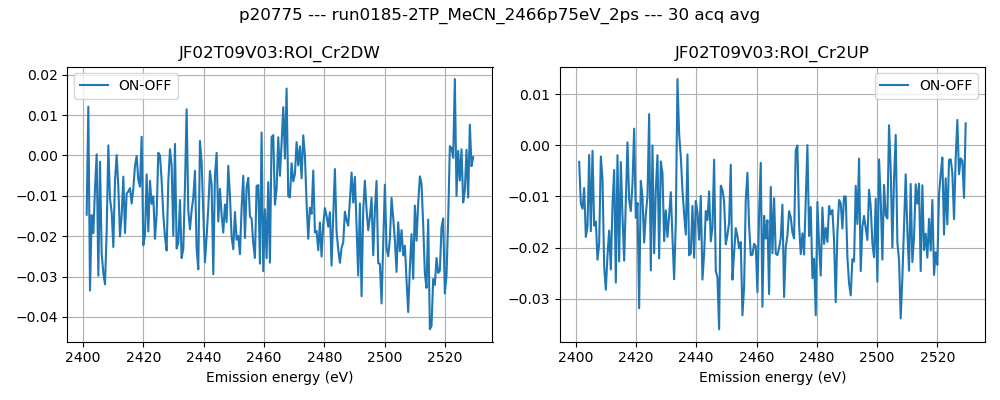

In [26]:
# energy_calib = True
bin_ = 3

#########################################################

fig, axs = plt.subplots(nrows=1, ncols=len(ROIs), figsize=(10,4))
plt.suptitle(titlestring+' --- {} acq avg'.format(len(spectra_on)))
for i, (key, ax) in enumerate(zip(ROIs, axs.flatten())):
    spec2plot_on = s_on[key]
    spec2plot_off = s_off[key]
    plt.sca(ax)
    xaxis = np.arange(np.array(meta[key+'-roi']).flatten()[-2], np.array(meta[key+'-roi']).flatten()[-1], 1)
    x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spec2plot_on, spec2plot_off, xaxis, bin_)
    xlabel = 'JF pixel'
    if energy_calib:
        x_axis_rebin = (x_axis_rebin-b)/m
        xlabel = 'Emission energy (eV)'
    
    plt.plot(x_axis_rebin, spectrum_ON_rebin-spectrum_OFF_rebin, label = 'ON-OFF')
    #plt.fill_between(x_axis_rebin, low_err, high_err, color='lightblue')
    plt.legend (loc='best')
    plt.title(key)
    plt.xlabel(xlabel)
    plt.grid()
plt.tight_layout()

print ('binsize is {:.2f} eV'.format(bin_/5.4))

In [ ]:
nshots = 500
threshold_low = 2
threshold_high = 50

######################################################################

total_image, total_image_thr, total_for_hist, total_for_hist_thr = \
XES_static_full(fc.selected, pgroup, threshold_low, threshold_high, nshots)

In [ ]:
plt.figure(figsize=(9,5))
plt.suptitle(fc.selected_filename)
plt.subplots_adjust(wspace=0.5)

plt.subplot(221)
plt.imshow(total_image_thr, origin="lower", aspect='auto', vmin=0, vmax=1)
plt.title("with threshold = {}".format(threshold_low))
plt.colorbar()

plt.subplot(223)
plt.title("Histogram with threshold = {}".format(threshold_low))
plt.hist(total_for_hist_thr.ravel(), bins=np.arange(0.1,50,0.1))
plt.yscale('log')

plt.subplot(222)
plt.imshow(total_image, origin="lower", aspect='auto', vmin=0, vmax=1)
plt.title("without threshold")
plt.colorbar()

plt.subplot(224)
plt.title("Histogram without threshold")
plt.hist(total_for_hist.ravel(), bins=np.arange(0.1,50,0.1))
plt.yscale('log')

plt.tight_layout()
plt.show()

## Check line correction on one ROI

In [ ]:
roi1 = (5050, 5200, 130, 290) #signal CRY2 low
roi2 = (5050, 5200, 310, 370) #signan CRY2 up

roi3 = (6460, 8540, 125, 225) #signal CRY1 low
roi4 = (8400, 8540, 250, 350) #signal CRY1 up

chosen_roi = roi1

#########################################
from scipy.signal import find_peaks

cropped_roi = crop_roi(total_image_thr, chosen_roi)

maxvalue = np.max(cropped_roi.sum(axis=0))
refpxl = np.array(find_peaks(cropped_roi.sum(axis=0), height=maxvalue/2))[0][0]

cropped_roi_corrected = line_rectifier(cropped_roi, 5, refpxl)

In [ ]:
plt.figure()
plt.suptitle(fc.selected_filename)

plt.subplot(221)
plt.title("raw data")
plt.imshow(cropped_roi,origin= 'lower', vmax = 1)

plt.subplot(222)
plt.title("corrected data")
plt.imshow(cropped_roi_corrected,origin= 'lower', vmax = 1)

plt.subplot(223)
plt.title(chosen_roi)
plt.plot(cropped_roi.sum(axis=0))

plt.subplot(224)
plt.title(chosen_roi)
plt.plot(cropped_roi_corrected.sum(axis=0))
plt.show()

plt.tight_layout()

## Next cells for a single file, ONLY JF file!

In [ ]:
pgroup='p20537'
fc = FileChooser(f'/sf/alvra/data/{pgroup}/raw/')
fc.use_dir_icons = True
display(fc)

In [ ]:
roi1 = (2900, 3100, 183, 260) #signal CRY2 low
roi2 = (2950, 3100, 250, 330) #signal CRY2 up

roi3 = (7300, 7500, 200, 240) #signal CRY1 low
roi4 = (7300, 7500, 270, 310) #signal CRY1 up

threshold_low = 2
threshold_high = 10
nshots = None

correctFlag = (True,True,False,False)
binsize=4

######################################################################################

spectrum_roi1, spectrum_roi2, spectrum_roi3, spectrum_roi4, pids = \
XES_static_4ROIs(fc.selected, pgroup, roi1, roi2, roi3, roi4, threshold_low, threshold_high, nshots, correctFlag, binsize)

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.suptitle(fc.selected_filename)

binarray = [1,1,1,1] # change the bin size if wanted, 1 is every pixel
spectrumarray = [spectrum_roi1, spectrum_roi2, spectrum_roi3, spectrum_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    x_axis = np.arange(roiarray[i][0], roiarray[i][1])
    x_axis_rebin, spectrum_rebin, low_err, high_err = plot_tool_static(spectrumarray[i], x_axis, binarray[i])
    location = 221+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.plot(x_axis_rebin,spectrum_rebin)
    ax.fill_between(x_axis_rebin, low_err, high_err, color='lightblue')
    plt.grid()
    plt.xlabel('JF pixel')

    ax.set_title(str(roiarray[i]))
plt.tight_layout()

## Now with Energy calibration 

In [ ]:
m_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_m_all.txt')
b_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_b_all.txt')

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.suptitle(fc.selected_filename)

binarray = [1,1,1,1] # change the bin size if wanted, 1 is every pixel
spectrumarray = [spectrum_roi1, spectrum_roi2, spectrum_roi3, spectrum_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    x_axis = np.linspace(roiarray[i][0]*m_all[i]+b_all[i], roiarray[i][1]*m_all[i]+b_all[i], roiarray[i][1]-roiarray[i][0])
    
    x_axis_rebin, spectrum_rebin, low_err, high_err = plot_tool_static(spectrumarray[i], x_axis, binarray[i])
    location = 221+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.plot(x_axis_rebin,spectrum_rebin)
    ax.fill_between(x_axis_rebin, low_err, high_err, color='lightblue')
    plt.grid()
    plt.xlabel('Emission energy (eV)')

    ax.set_title(str(roiarray[i]))
plt.tight_layout()

## Next cells for a summing up identical file, ONLY JF file!

In [ ]:
datalist = []
for file in glob('/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_250fs_3002p8eV_newCRY1/*JF*'):
    datalist.append(file)
datalist = sorted(datalist)#, key = os.path.getmtime)
patch = datalist[:4]
print (len(patch))
patch

In [ ]:
roi1 = (2900, 3100, 180, 240) #signal CRY2 low
roi2 = (2950, 3100, 260, 320) #signal CRY2 up

roi3 = (7300, 7500, 200, 240) #signal CRY1 low
roi4 = (7300, 7500, 270, 310) #signal CRY1 up

threshold_low = 2
threshold_high = 10
nshots = None

######################################################################################
from alvra_tools import clock
clock_int = clock.Clock()

spectrum_roi1_all = []
spectrum_roi2_all = []
spectrum_roi3_all = []
spectrum_roi4_all = []

for JF_single_file in patch:
    
    spectrum_roi1, spectrum_roi2, spectrum_roi3, spectrum_roi4, pids = \
    XES_static_4ROIs(JF_single_file, pgroup, roi1, roi2, roi3, roi4, threshold_low, threshold_high, nshots)
    
    spectrum_roi1_all.append(spectrum_roi1)
    spectrum_roi2_all.append(spectrum_roi2)
    spectrum_roi3_all.append(spectrum_roi3)
    spectrum_roi4_all.append(spectrum_roi4)
    
    clear_output(wait=True)
    print ("It took", clock_int.tick(), "seconds to process this file")

spectrum_roi1_all = np.asarray(spectrum_roi1_all)
spectrum_roi2_all = np.asarray(spectrum_roi2_all)
spectrum_roi3_all = np.asarray(spectrum_roi3_all)
spectrum_roi4_all = np.asarray(spectrum_roi4_all)

print ("It took {} seconds to process {} files".format(clock_int.tock(), len(patch)))

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.suptitle('{} files <-- {}'.format(len(patch),patch[0].split('/')[-2]))

spectrum_roi1 = np.mean(spectrum_roi1_all, axis = 0)
spectrum_roi2 = np.mean(spectrum_roi2_all, axis = 0)
spectrum_roi3 = np.mean(spectrum_roi3_all, axis = 0)
spectrum_roi4 = np.mean(spectrum_roi4_all, axis = 0)

binarray = [1,1,1,1] # change the bin size if wanted, 1 is every pixel
spectrumarray = [spectrum_roi1, spectrum_roi2, spectrum_roi3, spectrum_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    x_axis = np.arange(roiarray[i][0], roiarray[i][1])
    x_axis_rebin, spectrum_rebin, low_err, high_err = plot_tool_static(spectrumarray[i], x_axis, binarray[i])
    location = 221+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.plot(x_axis_rebin,spectrum_rebin)
    ax.fill_between(x_axis_rebin, low_err, high_err, color='lightblue')
    plt.grid()
    plt.xlabel('JF pixel')

    ax.set_title(str(roiarray[i]))
plt.tight_layout()

## Now with Energy calibration 

In [ ]:
m_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_m_all.txt')
b_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_b_all.txt')

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.suptitle(fc.selected_filename)

binarray = [1,1,1,1] # change the bin size if wanted, 1 is every pixel
spectrumarray = [spectrum_roi1, spectrum_roi2, spectrum_roi3, spectrum_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    x_axis = np.linspace(roiarray[i][0]*m_all[i]+b_all[i], roiarray[i][1]*m_all[i]+b_all[i], roiarray[i][1]-roiarray[i][0])
    
    x_axis_rebin, spectrum_rebin, low_err, high_err = plot_tool_static(spectrumarray[i], x_axis, binarray[i])
    location = 221+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.plot(x_axis_rebin,spectrum_rebin)
    ax.fill_between(x_axis_rebin, low_err, high_err, color='lightblue')
    plt.grid()
    plt.xlabel('Emission energy (eV)')

    ax.set_title(str(roiarray[i]))
plt.tight_layout()

In [ ]:
def interpstuff(RIXS_2D, xaxis, energy):
    indexinter = np.arange(np.shape(RIXS_2D)[0])
    interp_axis = np.arange((xaxis - energy[-1])[-1], (xaxis - energy[0])[0], xaxis[0]-xaxis[1])

    RIXS_roi1_interp = []

    for index in indexinter:
        RIXS_roi1_interp.append(np.interp(interp_axis, -(xaxis - energy[index]), np.array(RIXS_2D)[index,:]))
        
    return (interp_axis, RIXS_roi1_interp)

In [ ]:
indexinter = np.arange(np.shape(RIXS_roi1)[0])
interp_axis1 = np.arange((xaxis1 - Energy_eV[-1])[-1], (xaxis1 - Energy_eV[0])[0], xaxis1[0]-xaxis1[1])

RIXS_roi1_interp = []

for index in indexinter:
    RIXS_roi1_interp.append(np.interp(interp_axis, -(xaxis1 - Energy_eV[index]), np.array(RIXS_roi1)[index,:]))

In [ ]:
interp_axis1, RIXS_map_interp1 = interpstuff(RIXS_roi1, xaxis1, Energy_eV)
interp_axis2, RIXS_map_interp2 = interpstuff(RIXS_roi2, xaxis2, Energy_eV)
interp_axis3, RIXS_map_interp3 = interpstuff(RIXS_roi3, xaxis3, Energy_eV)
interp_axis4, RIXS_map_interp4 = interpstuff(RIXS_roi4, xaxis4, Energy_eV)

In [ ]:
plt.figure(figsize=(8,8))
plt.suptitle(fc.selected_filename, fontsize=12)

plt.subplot(221)
plt.imshow(RIXS_roi1_interp, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[interp_axis1[0], interp_axis1[-1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=10)
plt.xlim(-10,20)
plt.xlabel('Energy loss (eV)')
plt.ylabel('Photon energy (eV)')
plt.show()

plt.subplot(222)
plt.imshow(RIXS_roi2_interp, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[interp_axis2[0], interp_axis2[-1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=10)
plt.xlim(-10,20)
plt.xlabel('Energy loss (eV)')
plt.ylabel('Photon energy (eV)')
plt.show()

plt.subplot(223)
plt.imshow(RIXS_roi3_interp, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[interp_axis3[0], interp_axis3[-1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=10)
plt.xlim(-10,20)
plt.xlabel('Energy loss (eV)')
plt.ylabel('Photon energy (eV)')
plt.show()

plt.subplot(224)
plt.imshow(RIXS_roi4_interp, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[interp_axis4[0], interp_axis4[-1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=10)
plt.xlim(-10,20)
plt.xlabel('Energy loss (eV)')
plt.ylabel('Photon energy (eV)')
plt.show()

plt.tight_layout()
#plt.savefig(savedir+'/RIXS_Eloss_Si111_lower_Rhacac.png')

In [ ]:
indexlist = np.arange(65,100,1)
Energy_eV[indexlist]

In [ ]:
common_axis = np.arange((xaxis3 - Energy_eV[100])[-1], (xaxis3 - Energy_eV[0])[0], xaxis3[0]-xaxis3[1])

total_roi3 = 0
plt.figure()
for index in indexlist:
    #plt.plot(xaxis3 - Energy_eV[0],np.array(RIXS_roi3)[0,:], label = 'E={}'.format(np.round(Energy_eV[0],1)))
    total_roi3 +=  np.interp(common_axis, -(xaxis3 - Energy_eV[index]), np.array(RIXS_roi3)[index,:])
    plt.plot(common_axis, np.interp(common_axis, -(xaxis3 - Energy_eV[index]), np.array(RIXS_roi3)[index,:]))
plt.grid()
plt.show()

In [ ]:
plt.figure()
plt.title(fc.selected_filename)
plt.plot(common_axis, total_roi3)

plt.grid()

plt.xlim(-10,10)
#plt.ylim(0,700)
plt.xlabel('Energy loss (eV)')

plt.show()

plt.savefig(savedir+'/elastic_Si111_lower_Rhacac.png')

In [ ]:
indexlist = np.arange(45,56,1)
indexlist

In [ ]:
plt.figure()
plt.title(fc.selected_filename)
plt.plot(xaxis3 - Energy_eV[0], np.array(RIXS_roi3)[0,:], label = 'E={}'.format(np.round(Energy_eV[0],1)))
for index in indexlist:
    #offset += 20
    plt.plot(xaxis3 - Energy_eV[index], np.array(RIXS_roi3)[index,:], label = 'E={}'.format(np.round(Energy_eV[index],1)))

plt.plot(xaxis3 - Energy_eV[50], np.array(RIXS_roi3)[50,:], label = 'E={}'.format(np.round(Energy_eV[50],1)))
plt.xlim(-30,10)
plt.legend(loc='best')
plt.xlabel('Energy loss (eV)')
plt.ylabel('Number of Photons')
plt.ylim(0,250)
plt.grid()
plt.show()

plt.savefig(savedir+'/resonances_Si111.png')

In [ ]:
from scipy.optimize import curve_fit

class Fit:
    
    def __init__(self, func, estim, p0=None):
        self.func = func
        self.estim = estim
        self.p0 = self.popt = p0
        self.pcov = None
   
    def estimate(self, x, y):
        self.p0 = self.popt = self.estim(x,y)

    def fit(self, x, y):
        self.popt, self.pcov = curve_fit(self.func, x, y, p0=self.p0)
    
    def eval(self, x):
        return self.func(x, *self.popt)

In [ ]:
fit.popt

In [ ]:


fit = Fit(gaussian, estimate_gaussian_parameters)
fit.estimate(xaxis3 - Energy_eV[0], np.array(RIXS_roi3)[0,:])
fit.p0 = better_p0(fit.p0, 0, 0)

fit.fit(xaxis3 - Energy_eV[0],np.array(RIXS_roi3)[0,:])


plt.figure()
plt.plot(xaxis3 - Energy_eV[0], np.array(RIXS_roi3)[0,:], label = 'E={}'.format(np.round(Energy_eV[0],1)))
plt.plot(xaxis3 - Energy_eV[0], fit.eval(xaxis3 - Energy_eV[0]), label = 'E={}'.format(np.round(Energy_eV[0],1)))

plt.show()
print('width = {}'.format(np.abs(fit.popt[2]*2.55)))

In [ ]:
datalist = []
for file in glob('/sf/alvra/data/p19262/raw/scan_data/027_Rh_foil*'):
    datalist.append(file)
datalist = sorted(datalist)#, key = os.path.getmtime)
patch = datalist[:-1]
patch

In [ ]:
roi1 = (2600, 3600, 200, 260) #signal 1
roi2 = (2600, 3600, 100, 160) #bkg 1

roi3 = (5900, 6900, 200, 260) #signal 2
roi4 = (5900, 6900, 100, 160) #bkg 2

threshold_low = 2.0
threshold_high = 10

channel_list = ['JF02T09V02']

######################################################################################
from sfdata import SFScanInfo

RIXS_roi1_all = []
XAS_roi1_all = []
RIXS_roi3_all = []
XAS_roi3_all = []

for json_file in patch:

    scan = SFScanInfo(fc.selected)
    Energy_eV = scan.readbacks

    XAS_roi1 = []
    XAS_roi3 = []
    calibration = []
    RIXS_roi1 = []
    RIXS_roi3 = []

    for i, step in enumerate(scan.files):

        fn = step[3]
        print (json_file.split('/')[-1])
        print ("File {} out of {}: Processing {}".format(i+1, len(scan.files), fn.split('/')[-1]))

        spectrum_roi1 = 0
        spectrum_roi2 = 0
        spectrum_roi3 = 0
        spectrum_roi4 = 0

        nshots = None

        images_roi1, images_roi2, images_roi3, images_roi4, pids = \
        load_crop_JF_batches(fn, roi1, roi2, roi3, roi4, nshots=nshots)

        images_roi1_thr = images_roi1.copy()
        images_roi1_thr[images_roi1 < threshold_low] = 0
        images_roi1_thr[images_roi1 > threshold_high] = 0

        images_roi2_thr = images_roi2.copy()
        images_roi2_thr[images_roi2 < threshold_low] = 0
        images_roi2_thr[images_roi2 > threshold_high] = 0

        images_roi3_thr = images_roi3.copy()
        images_roi3_thr[images_roi3 < threshold_low] = 0
        images_roi3_thr[images_roi3 > threshold_high] = 0

        images_roi4_thr = images_roi4.copy()
        images_roi4_thr[images_roi4 < threshold_low] = 0
        images_roi4_thr[images_roi4 > threshold_high] = 0


        spectrum_roi1  = images_roi1_thr.sum(axis = 1).sum(axis = 0)
        spectrum_roi2  = images_roi2_thr.sum(axis = 1).sum(axis = 0)
        spectrum_roi3  = images_roi3_thr.sum(axis = 1).sum(axis = 0)
        spectrum_roi4  = images_roi4_thr.sum(axis = 1).sum(axis = 0)

        XAS_roi1.append(np.abs((spectrum_roi1 - spectrum_roi2).sum()))
        XAS_roi3.append(np.abs((spectrum_roi3 - spectrum_roi4).sum()))
        #print (np.argmax(spectrum_roi3 - spectrum_roi4))
        calibration.append(np.argmax(spectrum_roi1 - spectrum_roi2))

        RIXS_roi1.append(spectrum_roi1 - spectrum_roi2)
        RIXS_roi3.append(spectrum_roi3 - spectrum_roi4)
        clear_output(wait=True)
        print ("It took", clock.tick(), "seconds to process this file")

    RIXS_roi1_all.append(RIXS_roi1)
    XAS_roi1_all.append(XAS_roi1)
    
    RIXS_roi3_all.append(RIXS_roi3)
    XAS_roi3_all.append(XAS_roi3)
    
    print ("\nJob done! It took", clock.tock(), "seconds to process", len(scan.files), "file(s)")

RIXS_roi1_all = np.asarray(RIXS_roi1_all)
XAS_roi1_all = np.asarray(XAS_roi1_all)
RIXS_roi3_all = np.asarray(RIXS_roi3_all)
XAS_roi3_all = np.asarray(XAS_roi3_all)



In [ ]:
m1 = -0.21348314606741572
b1 = 3001.3 - 2957.4*m1

m3 = -(1/4.913043478260869) 
b3 = 3001.3 - 6179*m3  

#m=1
#b=0
xaxis1 = np.linspace(roi1[0]*m1+b1, roi1[1]*m1+b1, roi1[1]-roi1[0])
xaxis3 = np.linspace(roi3[0]*m3+b3, roi3[1]*m3+b3, roi3[1]-roi3[0])


plt.figure(figsize=(8,8))
plt.suptitle('11 RIXS from {}'.format(json_file.split('/')[-1]), fontsize=12)

plt.subplot(211)
plt.title('Si111 crystals')
plt.imshow(RIXS_roi1_all_photons, label="Ka", aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[xaxis1[0], xaxis1[-1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=100)
plt.gca().invert_xaxis()
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.colorbar()
plt.legend(loc="best")

plt.subplot(212)
plt.title('SiO2 (11-20) crystals')
plt.imshow(RIXS_roi3_all_photons, aspect = 'auto', cmap = "bwr", label="Kb", origin ="lower", \
           extent=[xaxis3[0], xaxis3[-1], Energy_eV[0],Energy_eV[-1]], vmin=0, vmax=100)
plt.gca().invert_xaxis()
plt.xlabel("Emission energy (eV)")
plt.ylabel("Incident energy (eV)")
plt.legend(loc="best")
plt.colorbar()

plt.tight_layout()
plt.show()

plt.savefig(savedir+'/RIXS_plane_avg_2')

In [ ]:
1/((2876 - 2787) / 19)

In [ ]:
plt.figure()
plt.title(fc.selected_filename)
plt.plot(Energy_eV,np.mean(np.array(RIXS_roi3)[:,263:265],axis=1)/np.max(np.mean(np.array(RIXS_roi3)[:,263:265],axis=1)), label ='E=3004.4 eV' )
plt.plot(Energy_eV,np.array(RIXS_roi3)[:,279]/np.max(np.array(RIXS_roi3)[:,279]), label ='E=3001.3 eV')
plt.legend(loc='best')
plt.xlabel('Photon Energy (eV)')
plt.ylabel('Intensity (arb. units)')

plt.grid()
plt.show()

plt.savefig(savedir+'/Lb215_vs_Vtc')

In [ ]:
plt.figure()
plt.title(fc.selected_filename)
plt.plot(xaxis1, np.sum(np.array(RIXS_roi1)[-20:,:], axis =0))
plt.grid()
plt.xlim(2975, 3050)
plt.axvline(3001.3, color = 'r')
plt.axvline(3004.4, color = 'g')
plt.ylabel('Number of photons')
plt.xlabel('Energy (eV)')

plt.show()
#plt.savefig(savedir+'/Lb_VtC_integrated_Si111')

In [ ]:
plt.figure()
plt.suptitle('11 RIXS from {}'.format(json_file.split('/')[-1]), fontsize=12)
plt.plot(Energy_eV, np.mean(XAS_roi3_all, axis=0))
plt.grid()
plt.xlabel('Energy (eV)')
plt.show()
plt.savefig(savedir+'/XANES_VonHamos.png')

## Next cells for an energy, any channel (BSDATA & JF) 

In [ ]:
fc = FileChooser('/sf/alvra/data/p18442/res/scan_info')
fc.use_dir_icons = True
display(fc)

In [ ]:
channel_list = [channel_PIPS_fluo, 'JF02T09V02']

roi1 = (5000, 5150, 220, 290) # Ru La ROIs
roi2 = (5000, 5150, 290, 360) 

roi3 = (2000, 2200, 10, 210)   # Lb _not set correctly!
roi4 = (2000, 2200, 230, 430)   # Kb_background


threshold_low = 2

####################################################################################################3
clock = Clock()
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Energy_eV = scan.readbacks

XAS_roi1 = []
XAS_roi3 = []
calibration = []
RIXS_roi1 = []
RIXS_roi3 = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    
    spectrum_roi1 = 0
    spectrum_roi2 = 0
    spectrum_roi3 = 0
    spectrum_roi4 = 0
    
    results = load_data_compact(channel_list, step)
    
    Data_fluo = results[channel_PIPS_fluo]
    images = results['JF02T09V02']
    
    images_roi1 = crop_roi(images, roi1)
    images_roi2 = crop_roi(images, roi2)
    images_roi3 = crop_roi(images, roi3)
    images_roi4 = crop_roi(images, roi4)
    
    images_roi1_thr = images_roi1.copy()
    images_roi1_thr[images_roi1 < threshold_low] = 0
    #images_roi1_thr[images_roi1 > threshold_high] = 0
    
    images_roi2_thr = images_roi2.copy()
    images_roi2_thr[images_roi2 < threshold_low] = 0
    #images_roi2_thr[images_roi2 > threshold_high] = 0
    
    images_roi3_thr = images_roi3.copy()
    images_roi3_thr[images_roi3 < threshold_low] = 0
    #images_roi3_thr[images_roi3 > threshold_high] = 0
    
    images_roi4_thr = images_roi4.copy()
    images_roi4_thr[images_roi4 < threshold_low] = 0
    #images_roi4_thr[images_roi4 > threshold_high] = 0
    
    spectrum_roi1  = images_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi2  = images_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi3  = images_roi3_thr.sum(axis = 1).sum(axis = 0)
    spectrum_roi4  = images_roi4_thr.sum(axis = 1).sum(axis = 0)
    
    XAS_roi1.append(np.abs((spectrum_roi1 - spectrum_roi2).sum()))
    XAS_roi3.append(np.abs((spectrum_roi3 - spectrum_roi4).sum()))
    #print (np.argmax(spectrum_roi3 - spectrum_roi4))
    calibration.append(np.argmax(spectrum_roi1 - spectrum_roi2))

    RIXS_roi1.append(spectrum_roi1 - spectrum_roi2)
    RIXS_roi3.append(spectrum_roi3 - spectrum_roi4)
    
    print ("It took", clock.tick(), "seconds to process this file")
    
XAS_roi1 = np.array(XAS_roi1)
XAS_roi3 = np.array(XAS_roi3)

calibration = np.array(calibration)
RIXS_roi1 = np.array(RIXS_roi1)
RIXS_roi3 = np.array(RIXS_roi3)

print ("\nJob done! It took", clock.tock(), "seconds to process all the files")

In [ ]:
plt.figure(figsize=(8,4))
plt.suptitle(fc.selected, fontsize=12)
plt.subplot(211)
plt.imshow(RIXS_roi1, label="Ka", aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=5000)
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.colorbar()
plt.legend(loc="best")

plt.subplot(212)
plt.imshow(RIXS_roi3, aspect = 'auto', cmap = "bwr", label="Kb", origin ="lower", \
           extent=[roi3[0], roi3[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=10)
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")
plt.legend(loc="best")
plt.colorbar()
plt.show()


In [ ]:
plt.figure(figsize=(7,6))
plt.suptitle(json_file, fontsize=12)

plt.plot(Energy_eV, XAS_roi1,label="Ka", marker='.')
plt.xlabel("Energy (eV)")
plt.ylabel("Counts")
plt.legend(loc="best")
plt.grid()

plt.show()

## Next cells for a single file, any channel (BSDATA & JF) 

In [ ]:
fc = FileChooser('/sf/alvra/data/p19262/raw/scan_info')
fc.use_dir_icons = True
display(fc)

In [ ]:
data = SFDataFiles('/sf/alvra/data/p18938/raw/XES_jet/run_008899*')

channel_list = [channel_PIPS_fluo, channel_Izero117, 'JF02T09V02']

roi1 = (7740, 7880, 290, 340) #signal 1
roi2 = (7740, 7880, 385, 435) #bkg 1

roi3 = (5080, 5220, 210, 250) #signal 2
roi4 = (5080, 5220, 145, 185) #bkg 2

threshold_low = 5

##########################################################
clock = Clock()
spectrum_roi1 = 0
spectrum_roi2 = 0
spectrum_roi3 = 0
spectrum_roi4 = 0
print (data.fnames[0])

results = load_data_compact_JF(channel_list, data, roi1, roi2, roi3, roi4)

data.close()

Data_fluo = results[channel_PIPS_fluo]
images_roi1 = results['JFroi1']
images_roi2 = results['JFroi2']
images_roi3 = results['JFroi3']
images_roi4 = results['JFroi4']

images_roi1_thr = images_roi1.copy()
images_roi1_thr[images_roi1 < threshold_low] = 0
#images_roi1_thr[images_roi1 > threshold_high] = 0

images_roi2_thr = images_roi2.copy()
images_roi2_thr[images_roi2 < threshold_low] = 0
#images_roi2_thr[images_roi2 > threshold_high] = 0

images_roi3_thr = images_roi3.copy()
images_roi3_thr[images_roi3 < threshold_low] = 0
#images_roi3_thr[images_roi3 > threshold_high] = 0

images_roi4_thr = images_roi4.copy()
images_roi4_thr[images_roi4 < threshold_low] = 0
#images_roi4_thr[images_roi4 > threshold_high] = 0

spectrum_roi1 = images_roi1_thr.sum(axis = 1).sum(axis = 0)
spectrum_roi2 = images_roi2_thr.sum(axis = 1).sum(axis = 0)
spectrum_roi3 = images_roi3_thr.sum(axis = 1).sum(axis = 0)
spectrum_roi4 = images_roi4_thr.sum(axis = 1).sum(axis = 0)

print ("It took", clock.tick(), "seconds to process this file")

In [ ]:
spectrum_bkg_roi1 = spectrum_roi1  - spectrum_roi2
err_spectrum_ro1 = np.sqrt(spectrum_roi1)
err_bkg_2 = np.sqrt(spectrum_roi2)

spectrum_bkg_roi3 = spectrum_roi3 - spectrum_roi4
err_spectrum_roi3 = np.sqrt(spectrum_roi3)
err_bkg_4 = np.sqrt(spectrum_roi4)


bin1_ = 1   # change the bin size if wanted, 1 is every pixel
bin3_ = 1

spectrum_bkg_1 = spectrum_bkg_roi1.copy()
spectrum_bkg_3 = spectrum_bkg_roi3.copy()
x_axis_1 = np.arange(roi1[0], roi1[1])
x_axis_3 = np.arange(roi3[0], roi3[1])


spectrum_rebin1  = bin_sum(spectrum_bkg_1,  bin1_)
x_axis_rebin1 = bin_mean(x_axis_1, bin1_)
spectrum_rebin3  = bin_sum(spectrum_bkg_3,  bin3_)
x_axis_rebin3 = bin_mean(x_axis_3, bin3_)


#low_err_Ka= (spectrum_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#high_err_Kb= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)

#spectrumAllOutFoc=spectra_on_rebin1 + spectra_off_rebin1
plt.figure()
plt.subplot(211)
#plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin1, spectrum_rebin1, label="Ka", marker='.')
plt.legend(loc="best")
plt.grid()

plt.subplot(212)
#plt.title(scan_name + ", delay = {} ps".format(str(np.round(Delay_ps_single,3))))
plt.plot(x_axis_rebin3, spectrum_rebin3, label="Ka", marker='.')
plt.legend(loc="best")
plt.grid()

#plt.title(jf_file)
plt.xlabel("JF pixel")
plt.show()

In [ ]:
def edge_removal(module_edge, roi_removal, array):
    index_edge = module_edge - roi_removal[0]
    array_input = array.copy()
    print (array[index_edge-1:index_edge+3])
    array[index_edge] = array[index_edge-1]/2
    array[index_edge-1] = array[index_edge-1]/2

    array[index_edge+1] = array[index_edge+2]/2
    array[index_edge+2] = array[index_edge+2]/2 
    print (array[index_edge-1:index_edge+3])
    return array, array_input

In [ ]:
spectrum_ON_roi1, spectrum_ON_roi1_orig = edge_removal(6472, roi1, spectrum_ON_roi1) 
spectrum_OFF_roi1, spectrum_OFF_roi1_orig = edge_removal(6472, roi1, spectrum_OFF_roi1) 